In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = '/content/drive/MyDrive/Modulo11/Jef/Semana10/archive/spam.csv'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report

In [43]:
# Carregando o dataset
df = pd.read_csv(dataset_path, encoding='latin1')

# Visualizando as primeiras linhas
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [44]:
print(df.columns)


Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


## Análise Exploratória de Dados (EDA)

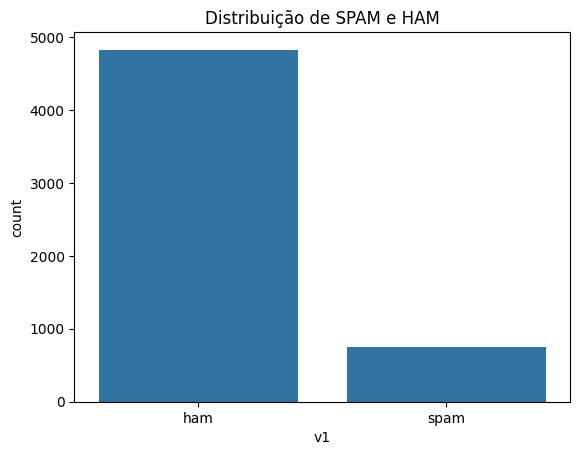

In [46]:
# Verificando a distribuição das classes
sns.countplot(data=df, x='v1')
plt.title("Distribuição de SPAM e HAM")
plt.show()

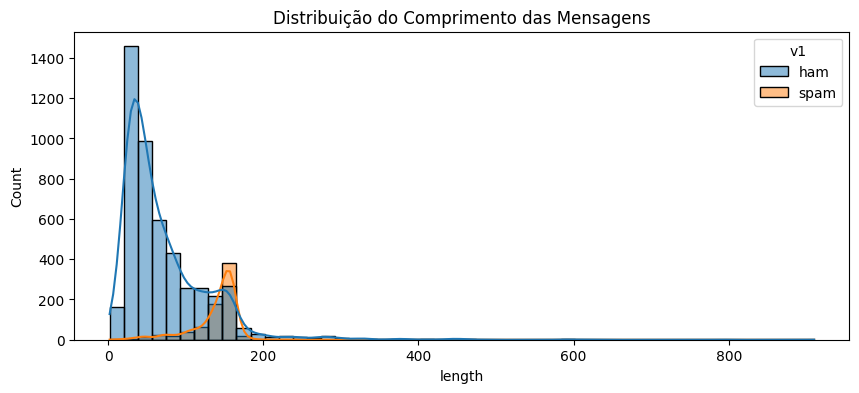

,length
v1,
ham,71.023627
spam,138.866131


In [48]:
# Comprimento das mensagens
df['length'] = df['v2'].astype(str).apply(len)

# Histograma de comprimento
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='length', hue='v1', bins=50, kde=True)
plt.title("Distribuição do Comprimento das Mensagens")
plt.show()

# Tamanho médio por classe
df.groupby('v1')['length'].mean()

In [ ]:
# Histograma de comprimento
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='length', hue='v1', bins=50, kde=True)
plt.title("Distribuição do Comprimento das Mensagens")
plt.show()

In [15]:
df = df.rename(columns={'v1': 'Label', 'v2': 'Body'})

##  3. Pré-processamento de Texto (NLP)

In [16]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', ' ', text)  # Remove punctuation and numbers
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['Body'].astype(str).apply(preprocess_text)
df[['Label', 'clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Label,clean_text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri wkli comp win fa cup final tkt st m...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah think goe usf live around though


In [17]:
df.dropna(subset=['Label', 'clean_text'], inplace=True)
df.head()

,Label,Body,Unnamed: 2,Unnamed: 3,Unnamed: 4,length,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61,nah think goe usf live around though


In [19]:
# Veja como os rótulos estão
print(df['Label'].unique())
print(df['Label'].value_counts())


['ham' 'spam']
Label
ham     4825
spam     747
Name: count, dtype: int64


In [20]:
print(df.columns)


Index(['Label', 'Body', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'length',
       'clean_text'],
      dtype='object')


## 4. Vetorização com GloVe

In [31]:
# 1. Limpeza da coluna 'Label'
df['Label'] = df['Label'].astype(str).str.strip().str.lower()
df = df[df['Label'].isin(['ham', 'spam'])]  # mantém apenas ham e spam

# 2. Limpeza da coluna de texto
df['clean_text'] = df['clean_text'].astype(str).str.strip()
df = df[df['clean_text'] != ""]

# 3. Mapeamento dos rótulos
df['label_num'] = df['Label'].map({'ham': 0, 'spam': 1})

# 4. Remove qualquer linha com NaN nos campos principais
df.dropna(subset=['clean_text', 'label_num'], inplace=True)

print("Linhas no df após limpeza final:", df.shape)
print("Valores únicos em Label:", df['Label'].unique())
print("Valores únicos em label_num:", df['label_num'].unique())


# 5. Split corretamente
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label_num'], test_size=0.2, random_state=42
)

# 6. Garante o tipo dos rótulos
y_train = np.array(y_train).astype('int32')
y_test = np.array(y_test).astype('int32')

# 7. Verifica se resolveu
print("y_test NaNs:", np.isnan(y_test).sum())


Linhas no df após limpeza final: (5564, 8)
Valores únicos em Label: ['ham' 'spam']
Valores únicos em label_num: [0 1]
y_test NaNs: 0


In [22]:
# 4. Separar os dados de treino e teste
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['Label'], test_size=0.2, random_state=42
)

# Após o split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['Label'].map({'ham': 0, 'spam': 1}), test_size=0.2, random_state=42
)

# Converte para DataFrame temporário e remove NaN
train_df = pd.DataFrame({'text': X_train_text, 'label': y_train})
test_df = pd.DataFrame({'text': X_test_text, 'label': y_test})

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Reconstrói os vetores
X_train_text = train_df['text']
y_train = train_df['label'].astype(int).values

X_test_text = test_df['text']
y_test = test_df['label'].astype(int).values


In [23]:
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

word_index = tokenizer.word_index
print(f"Total de palavras únicas: {len(word_index)}")

# Padding
X = pad_sequences(sequences, maxlen=100)
y = df['Label'].map({'ham': 0, 'spam': 1}).values

# Carregando embeddings GloVe
embedding_index = {}
with open('/content/drive/MyDrive/Modulo11/Jef/Semana10/glove.6B/glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


Total de palavras únicas: 6238


(5564, 100)

In [ ]:
# Matriz de embedding
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

X.shape

In [24]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,871,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,871,700 (7.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,871,700 (7.14 MB)

In [25]:
df.dropna(subset=['Label', 'clean_text'], inplace=True)
df.head()

,Label,Body,Unnamed: 2,Unnamed: 3,Unnamed: 4,length,clean_text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155,free entri wkli comp win fa cup final tkt st m...,1
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49,u dun say earli hor u c alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61,nah think goe usf live around though,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 548ms/step - accuracy: 0.8875 - loss: 0.3174 - val_accuracy: 0.9721 - val_loss: 0.0750
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 505ms/step - accuracy: 0.9764 - loss: 0.0796 - val_accuracy: 0.9775 - val_loss: 0.0660
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 496ms/step - accuracy: 0.9789 - loss: 0.0570 - val_accuracy: 0.9739 - val_loss: 0.0646
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 487ms/step - accuracy: 0.9848 - loss: 0.0561 - val_accuracy: 0.9820 - val_loss: 0.0590
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 534ms/step - accuracy: 0.9894 - loss: 0.0357 - val_accuracy: 0.9820 - val_loss: 0.0593


In [27]:
print("y_test (primeiros 10):", y_test[:10])
print("y_test dtype:", y_test.dtype)
print("Contém NaN em y_test?", np.isnan(y_test).sum())


y_test (primeiros 10): [0 1 0 0 0 0 0 1 0 0]
y_test dtype: int64
Contém NaN em y_test? 0


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
Acurácia: 0.9820


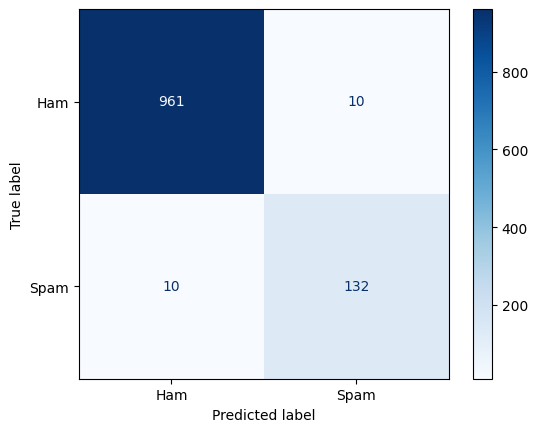

In [28]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Acurácia
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.show()

In [30]:
# Relatório completo (Precision, Recall, F1-score)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Relatório de Classificação:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       971
        Spam       0.93      0.93      0.93       142

    accuracy                           0.98      1113
   macro avg       0.96      0.96      0.96      1113
weighted avg       0.98      0.98      0.98      1113



##  Nova vetorização: TF-IDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [33]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()
X_tfidf.shape

(5564, 5000)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Split novamente para o TF-IDF (com os mesmos índices)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, df['label_num'], test_size=0.2, random_state=42
)

# Modelo MLP simples
model_tfidf = Sequential()
model_tfidf.add(Dense(128, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model_tfidf.add(Dropout(0.3))
model_tfidf.add(Dense(64, activation='relu'))
model_tfidf.add(Dense(1, activation='sigmoid'))

model_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento
history_tfidf = model_tfidf.fit(
    X_train_tfidf, y_train_tfidf, epochs=5, batch_size=64, validation_data=(X_test_tfidf, y_test_tfidf)
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8453 - loss: 0.5284 - val_accuracy: 0.8724 - val_loss: 0.1789
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9234 - loss: 0.1388 - val_accuracy: 0.9775 - val_loss: 0.0682
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9898 - loss: 0.0409 - val_accuracy: 0.9820 - val_loss: 0.0560
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9953 - loss: 0.0168 - val_accuracy: 0.9793 - val_loss: 0.0621
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9996 - loss: 0.0053 - val_accuracy: 0.9829 - val_loss: 0.0601


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Acurácia TF-IDF + MLP: 0.9829


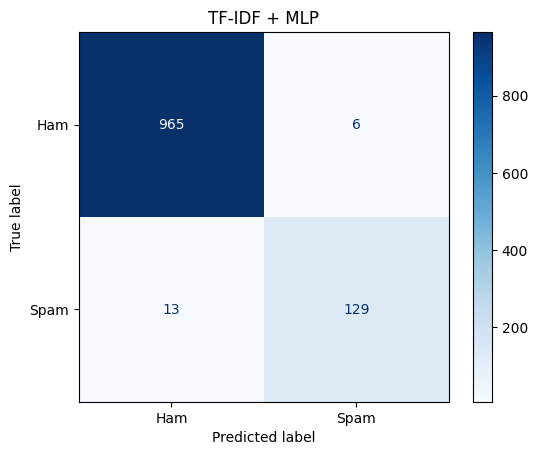

In [35]:
# Predição
y_pred_tfidf = (model_tfidf.predict(X_test_tfidf) > 0.5).astype("int32")

# Acurácia
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
print(f"Acurácia TF-IDF + MLP: {acc_tfidf:.4f}")

# Matriz de confusão
cm_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title("TF-IDF + MLP")
plt.show()


In [37]:
print(f"Acurácia LSTM + GloVe: {acc:.4f}")
print(f"Acurácia MLP + TF-IDF: {acc_tfidf:.4f}")


Acurácia LSTM + GloVe: 0.9820
Acurácia MLP + TF-IDF: 0.9829


In [39]:
from sklearn.metrics import classification_report

print("LSTM + GloVe")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

print("\ MLP + TF-IDF")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=["Ham", "Spam"]))


LSTM + GloVe
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       971
        Spam       0.93      0.93      0.93       142

    accuracy                           0.98      1113
   macro avg       0.96      0.96      0.96      1113
weighted avg       0.98      0.98      0.98      1113

\ MLP + TF-IDF
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       971
        Spam       0.96      0.91      0.93       142

    accuracy                           0.98      1113
   macro avg       0.97      0.95      0.96      1113
weighted avg       0.98      0.98      0.98      1113

